In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 'time_series_covid19_confirmed_US.csv',
                 'time_series_covid19_deaths_US.csv']:
    if os.path.exists(filename):
        os.remove(filename)
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)

CPU times: user 223 ms, sys: 47.2 ms, total: 270 ms
Wall time: 2.67 s


In [3]:
from datetime import datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]

        
confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

recovered_global_df

,Province/State,Country/Region,Lat,Long,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,...,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22,2021-08-23,2021-08-24,2021-08-25,2021-08-26,2021-08-27,2021-08-28,2021-08-29,2021-08-30,2021-08-31,2021-09-01,2021-09-02,2021-09-03,2021-09-04,2021-09-05,2021-09-06
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
261,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Filter out problematic data points (The West Bank and Gaza had a negative value, cruise ships were associated with Canada, etc.)
removed_states = "Recovered|Grand Princess|Diamond Princess"
removed_countries = "US|The West Bank and Gaza"

confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
recovered_global_df = recovered_global_df[~recovered_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
recovered_global_df = recovered_global_df[~recovered_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]

recovered_global_df

,Province_State,Country_Region,Lat,Long,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,...,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22,2021-08-23,2021-08-24,2021-08-25,2021-08-26,2021-08-27,2021-08-28,2021-08-29,2021-08-30,2021-08-31,2021-09-01,2021-09-02,2021-09-03,2021-09-04,2021-09-05,2021-09-06
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
261,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')


confirmed_global_melt_df

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases
0,Afghanistan,NaN,33.939110,67.709953,2020-01-22,0
1,Albania,NaN,41.153300,20.168300,2020-01-22,0
2,Algeria,NaN,28.033900,1.659600,2020-01-22,0
3,Andorra,NaN,42.506300,1.521800,2020-01-22,0
4,Angola,NaN,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
163939,Vietnam,NaN,14.058324,108.277199,2021-09-06,536788
163940,West Bank and Gaza,NaN,31.952200,35.233200,2021-09-06,356474
163941,Yemen,NaN,15.552727,48.516388,2021-09-06,8142
163942,Zambia,NaN,-13.133897,27.849332,2021-09-06,207167


In [6]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
0,Afghanistan,NaN,33.939110,67.709953,2020-01-22,0,0,0
1,Albania,NaN,41.153300,20.168300,2020-01-22,0,0,0
2,Algeria,NaN,28.033900,1.659600,2020-01-22,0,0,0
3,Andorra,NaN,42.506300,1.521800,2020-01-22,0,0,0
4,Angola,NaN,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
163939,Vietnam,NaN,14.058324,108.277199,2021-09-06,536788,13385,13385
163940,West Bank and Gaza,NaN,31.952200,35.233200,2021-09-06,356474,3744,3744
163941,Yemen,NaN,15.552727,48.516388,2021-09-06,8142,1530,1530
163942,Zambia,NaN,-13.133897,27.849332,2021-09-06,207167,3617,3617


In [7]:
# --- US ---# Data Processing
confirmed_us_df = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths_us_df = pd.read_csv('time_series_covid19_deaths_US.csv')

confirmed_us_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'], inplace=True, axis=1)
deaths_us_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Population'], inplace=True, axis=1)

confirmed_us_df.rename({'Long_': 'Long'}, axis=1, inplace=True)
deaths_us_df.rename({'Long_': 'Long'}, axis=1, inplace=True)

_convert_date_str(confirmed_us_df)
_convert_date_str(deaths_us_df)

# clean
confirmed_us_df = confirmed_us_df[~confirmed_us_df.Province_State.str.match("Diamond Princess|Grand Princess|Recovered|Northern Mariana Islands|American Samoa")]
deaths_us_df = deaths_us_df[~deaths_us_df.Province_State.str.match("Diamond Princess|Grand Princess|Recovered|Northern Mariana Islands|American Samoa")]

# --- Aggregate by province state ---
#confirmed_us_df.groupby(['Country_Region', 'Province_State'])
confirmed_us_df = confirmed_us_df.groupby(['Country_Region', 'Province_State']).sum().reset_index()
deaths_us_df = deaths_us_df.groupby(['Country_Region', 'Province_State']).sum().reset_index()

# remove lat, long.
confirmed_us_df.drop(['Lat', 'Long'], inplace=True, axis=1)
deaths_us_df.drop(['Lat', 'Long'], inplace=True, axis=1)

confirmed_us_melt_df = confirmed_us_df.melt(
    id_vars=['Country_Region', 'Province_State'], value_vars=confirmed_us_df.columns[2:], var_name='Date', value_name='ConfirmedCases')
deaths_us_melt_df = deaths_us_df.melt(
    id_vars=['Country_Region', 'Province_State'], value_vars=deaths_us_df.columns[2:], var_name='Date', value_name='Deaths')

train_us = confirmed_us_melt_df.merge(deaths_us_melt_df, on=['Country_Region', 'Province_State', 'Date'])

train_us

,Country_Region,Province_State,Date,ConfirmedCases,Deaths
0,US,Alabama,2020-01-22,0,0
1,US,Alaska,2020-01-22,0,0
2,US,Arizona,2020-01-22,0,0
3,US,Arkansas,2020-01-22,0,0
4,US,California,2020-01-22,0,0
...,...,...,...,...,...
32071,US,Virginia,2021-09-06,786910,11929
32072,US,Washington,2021-09-06,575490,6691
32073,US,West Virginia,2021-09-06,199300,3148
32074,US,Wisconsin,2021-09-06,745707,8536


In [8]:
train = pd.concat([train, train_us], axis=0, sort=False)

train_us.rename({'Country_Region': 'country', 'Province_State': 'province', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities'}, axis=1, inplace=True)
train_us['country_province'] = train_us['country'].fillna('') + '/' + train_us['province'].fillna('')

train_us

,country,province,date,confirmed,fatalities,country_province
0,US,Alabama,2020-01-22,0,0,US/Alabama
1,US,Alaska,2020-01-22,0,0,US/Alaska
2,US,Arizona,2020-01-22,0,0,US/Arizona
3,US,Arkansas,2020-01-22,0,0,US/Arkansas
4,US,California,2020-01-22,0,0,US/California
...,...,...,...,...,...,...
32071,US,Virginia,2021-09-06,786910,11929,US/Virginia
32072,US,Washington,2021-09-06,575490,6691,US/Washington
32073,US,West Virginia,2021-09-06,199300,3148,US/West Virginia
32074,US,Wisconsin,2021-09-06,745707,8536,US/Wisconsin


In [9]:
%%time
datadir = Path('/kaggle/input/covid19-global-forecasting-week-4')
datadir

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 26.9 µs


PosixPath('/kaggle/input/covid19-global-forecasting-week-4')

In [10]:
train

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
0,Afghanistan,NaN,33.93911,67.709953,2020-01-22,0,0,0.0
1,Albania,NaN,41.15330,20.168300,2020-01-22,0,0,0.0
2,Algeria,NaN,28.03390,1.659600,2020-01-22,0,0,0.0
3,Andorra,NaN,42.50630,1.521800,2020-01-22,0,0,0.0
4,Angola,NaN,-11.20270,17.873900,2020-01-22,0,0,0.0
...,...,...,...,...,...,...,...,...
32071,US,Virginia,NaN,NaN,2021-09-06,786910,11929,NaN
32072,US,Washington,NaN,NaN,2021-09-06,575490,6691,NaN
32073,US,West Virginia,NaN,NaN,2021-09-06,199300,3148,NaN
32074,US,Wisconsin,NaN,NaN,2021-09-06,745707,8536,NaN


In [11]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')
train

,country,province,Lat,Long,date,confirmed,fatalities,recovered,country_province
0,Afghanistan,NaN,33.93911,67.709953,2020-01-22,0,0,0.0,Afghanistan/
1,Albania,NaN,41.15330,20.168300,2020-01-22,0,0,0.0,Albania/
2,Algeria,NaN,28.03390,1.659600,2020-01-22,0,0,0.0,Algeria/
3,Andorra,NaN,42.50630,1.521800,2020-01-22,0,0,0.0,Andorra/
4,Angola,NaN,-11.20270,17.873900,2020-01-22,0,0,0.0,Angola/
...,...,...,...,...,...,...,...,...,...
32071,US,Virginia,NaN,NaN,2021-09-06,786910,11929,NaN,US/Virginia
32072,US,Washington,NaN,NaN,2021-09-06,575490,6691,NaN,US/Washington
32073,US,West Virginia,NaN,NaN,2021-09-06,199300,3148,NaN,US/West Virginia
32074,US,Wisconsin,NaN,NaN,2021-09-06,745707,8536,NaN,US/Wisconsin


# Worldwide Trend

In [12]:
ww_df = train.groupby('date')[['confirmed', 'fatalities']].sum().reset_index()
ww_df
ww_df['new_case'] = ww_df['confirmed'] - ww_df['confirmed'].shift(1)
ww_df['growth_factor'] = ww_df['new_case'] / ww_df['new_case'].shift(1)

# ww_df.tail()

In [13]:
ww_melt_df = pd.melt(ww_df, id_vars=['date'], value_vars=['confirmed', 'fatalities', 'new_case'])
ww_melt_df

,date,variable,value
0,2020-01-22,confirmed,557.0
1,2020-01-23,confirmed,655.0
2,2020-01-24,confirmed,941.0
3,2020-01-25,confirmed,1433.0
4,2020-01-26,confirmed,2118.0
...,...,...,...
1777,2021-09-02,new_case,631605.0
1778,2021-09-03,new_case,758577.0
1779,2021-09-04,new_case,460908.0
1780,2021-09-05,new_case,407257.0


In [14]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable', 
              title="全球確診/死亡病例數趨勢")
fig.show()

In [15]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable',
              title="全球確診/死亡病例數趨勢(日誌模式)",
             log_y=True)
fig.show()

In [16]:
ww_df['mortality'] = ww_df['fatalities'] / ww_df['confirmed']

fig = px.line(ww_df, x="date", y="mortality", 
              title="全球死亡率趨勢")
fig.show()

In [17]:
fig = px.line(ww_df, x="date", y="growth_factor", 
              title="全球成長因素趨勢")
fig.add_trace(go.Scatter(x=[ww_df['date'].min(), ww_df['date'].max()], y=[1., 1.], name='Growth factor=1.', line=dict(dash='dash', color=('rgb(255, 0, 0)'))))
fig.update_yaxes(range=[0., 5.])
fig.show()

In [18]:

country_df = train.groupby(['date', 'country'])[['confirmed', 'fatalities']].sum().reset_index()
country_df.tail()

,date,country,confirmed,fatalities
115825,2021-09-06,Vietnam,536788,13385
115826,2021-09-06,West Bank and Gaza,356474,3744
115827,2021-09-06,Yemen,8142,1530
115828,2021-09-06,Zambia,207167,3617
115829,2021-09-06,Zimbabwe,125671,4493


In [19]:
countries = country_df['country'].unique()
print(f'{len(countries)} countries are in dataset:\n{countries}')

195 countries are in dataset:
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel'

In [20]:
target_date = country_df['date'].max()

print('Date: ', target_date)
for i in [1, 100, 10000, 100000, 1000000, 10000000]:
    n_countries = len(country_df.query('(date == @target_date) & confirmed > @i'))
    print(f'{n_countries} countries have more than {i} confirmed cases')

Date:  2021-09-06
194 countries have more than 1 confirmed cases
186 countries have more than 100 confirmed cases
159 countries have more than 10000 confirmed cases
108 countries have more than 100000 confirmed cases
35 countries have more than 1000000 confirmed cases
3 countries have more than 10000000 confirmed cases


/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (8).

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 30906 missing from current font.

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 35386 missing from current font.

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 30149 missing from current font.

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 20363 missing from current font.

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 30452 missing from current font.

/home/yszhao/anaconda3/envs/python37_pytorch/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning:

Glyph 26041 missing 

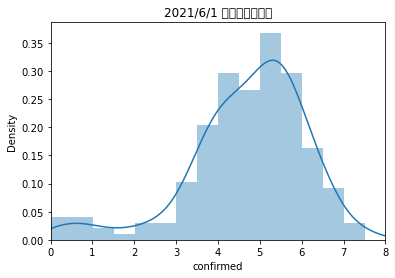

In [21]:
ax = sns.distplot(np.log10(country_df.query('date == "2021-06-01"')['confirmed'] + 1))
ax.set_title("2021/6/1 確診病例直方圖")
ax.set_xlim([0, 8])
ax.set_xticks(np.arange(9))
_ = ax.set_xticklabels(['0', '10', '100', '1k', '10k', '100k', '1m', '10m'])

In [ ]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 1000)').sort_values('confirmed', ascending=False)
top_country_melt_df = pd.melt(top_country_df, id_vars='country', value_vars=['confirmed', 'fatalities'])

In [ ]:
fig = px.bar(top_country_melt_df.iloc[::-1],
             x='value', y='country', color='variable', barmode='group',
             title=f'確診病例 / 死亡人數 {target_date}', text='value', height=1500, orientation='h')
fig.show()

In [ ]:
top30_countries = top_country_df.sort_values('confirmed', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date', y='confirmed', color='country',
              title=f'至今 TOP 30 國家的確診病例數 {target_date}')
fig.show()

In [ ]:
top30_countries = top_country_df.sort_values('fatalities', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date', y='fatalities', color='country',
              title=f'至今 TOP 30 國家的死亡病例數 {target_date}')
fig.show()

In [ ]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 100)')
top_country_df['mortality_rate'] = top_country_df['fatalities'] / top_country_df['confirmed']
top_country_df = top_country_df.sort_values('mortality_rate', ascending=False)

In [ ]:
fig = px.bar(top_country_df[:30].iloc[::-1],
             x='mortality_rate', y='country',
             title=f'高死亡率 TOP 30 國家： {target_date}', text='mortality_rate', height=800, orientation='h')
fig.show()

In [ ]:
fig = px.bar(top_country_df[-30:],
             x='mortality_rate', y='country',
             title=f'低死亡率 TOP 30 國家： {target_date}', text='mortality_rate', height=800, orientation='h')
fig.show()

In [ ]:
all_country_df = country_df.query('date == @target_date')
all_country_df['confirmed_log1p'] = np.log10(all_country_df['confirmed'] + 1)
all_country_df['fatalities_log1p'] = np.log10(all_country_df['fatalities'] + 1)
all_country_df['mortality_rate'] = all_country_df['fatalities'] / all_country_df['confirmed']

In [ ]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="confirmed_log1p", 
                    hover_name="country", hover_data=["confirmed", 'fatalities', 'mortality_rate'],
                    range_color=[all_country_df['confirmed_log1p'].min(), all_country_df['confirmed_log1p'].max()], 
                    color_continuous_scale="peach", 
                    title='存在確診病例的國家')

# I'd like to update colorbar to show raw values, but this does not work somehow...
# Please let me know if you know how to do this!!
trace1 = list(fig.select_traces())[0]
trace1.colorbar = go.choropleth.ColorBar(
    tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8],
    ticktext=['1', '10', '100', '1000','10000', '100000', '1000000', '10000000', '100000000'])
fig.show()

In [ ]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="fatalities_log1p", 
                    hover_name="country", range_color=[0, 6],
                    hover_data=['confirmed', 'fatalities', 'mortality_rate'],
                    color_continuous_scale="peach", 
                    title='死亡人數高的國家')
fig.show()

In [ ]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="mortality_rate", 
                    hover_name="country", range_color=[0, 0.10], 
                    color_continuous_scale="peach", 
                    title='死亡率高的國家')
fig.show()

In [ ]:
n_countries = 20
n_start_death = 10
fatality_top_countires = top_country_df.sort_values('fatalities', ascending=False).iloc[:n_countries]['country'].values
country_df['date'] = pd.to_datetime(country_df['date'])


df_list = []
for country in fatality_top_countires:
    this_country_df = country_df.query('country == @country')
    start_date = this_country_df.query('fatalities > @n_start_death')['date'].min()
    this_country_df = this_country_df.query('date >= @start_date')
    this_country_df['date_since'] = this_country_df['date'] - start_date
    this_country_df['fatalities_log1p'] = np.log10(this_country_df['fatalities'] + 1)
    this_country_df['fatalities_log1p'] -= this_country_df['fatalities_log1p'].values[0]
    df_list.append(this_country_df)

tmpdf = pd.concat(df_list)
tmpdf['date_since_days'] = tmpdf['date_since'] / pd.Timedelta('1 days')

In [ ]:
fig = px.line(tmpdf,
              x='date_since_days', y='fatalities_log1p', color='country',
              title=f'自 10 人死亡以來按國家劃分的死亡人數，截至 {target_date}')
fig.add_trace(go.Scatter(x=[0, 28], y=[0, 4], name='Double by 7 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 56], y=[0, 4], name='Double by 14 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 84], y=[0, 4], name='Double by 21 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.show()

In [ ]:
country_df['prev_confirmed'] = country_df.groupby('country')['confirmed'].shift(1)
country_df['new_case'] = country_df['confirmed'] - country_df['prev_confirmed']
country_df['new_case'].fillna(0, inplace=True)
top30_country_df = country_df[country_df['country'].isin(top30_countries)]

fig = px.line(top30_country_df,
              x='date', y='new_case', color='country',
              title=f'依國家/地區劃分的每日新增確診病例')
fig.show()

In [ ]:
country_df['avg_new_case'] = country_df.groupby('country')['new_case'].rolling(7).mean().reset_index(0, drop=True)
country_df['prev_new_case'] = country_df.groupby('country')['avg_new_case'].shift(1)
country_df['growth_factor'] = country_df['avg_new_case'] / country_df['prev_new_case']

country_df['growth_factor'].fillna(0, inplace=True)
top30_country_df = country_df[country_df['country'].isin(top30_countries)]

fig = px.line(top30_country_df,
              x='date', y='growth_factor', color='country',
              title=f'按國家/地區劃分的成長因子')
fig.add_trace(go.Scatter(x=[ww_df['date'].min(), ww_df['date'].max()], y=[1., 1.], name='Growth factor=1.', line=dict(dash='dash', color=('rgb(255, 0, 0)'))))
fig.update_yaxes(range=[0., 5.])
fig.show()

In [ ]:
country_df['date'] = country_df['date'].apply(str)
country_df['confirmed_log1p'] = np.log1p(country_df['confirmed'])
country_df['fatalities_log1p'] = np.log1p(country_df['fatalities'])

fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="confirmed", size='confirmed', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['confirmed'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19：確診病例趨勢', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="fatalities", size='fatalities', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['fatalities'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19：死亡病例趨勢', color_continuous_scale="portland")
fig.show()

In [ ]:
country_df.loc[country_df['new_case'] < 0, 'new_case'] = 0.
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="new_case", size='new_case', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['new_case'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19：每日新增病例趨勢', color_continuous_scale="portland")
fig.show()

In [ ]:
for country in countries:
    province = train.query('country == @country')['province'].unique()
    if len(province) > 1:       
        print(f'Country {country} has {len(province)} provinces: {province}')

# Zoom Up to US

In [ ]:
usa_state_code_df = pd.read_csv('USA_State_Code/usa_states2.csv')
train_us

In [ ]:
# Prepare data frame only for US. 

#train_us = train.query('country == "US"')
train_us['mortality_rate'] = train_us['fatalities'] / train_us['confirmed']

# Convert province column to its 2-char code name,
state_name_to_code = dict(zip(usa_state_code_df['state_name'], usa_state_code_df['state_code']))
train_us['province_code'] = train_us['province'].map(state_name_to_code)

# Only show latest days.
train_us_latest = train_us.query('date == @target_date')

In [ ]:
fig = px.choropleth(train_us_latest, locations='province_code', locationmode="USA-states",
                    color='confirmed', scope="usa", hover_data=['province', 'fatalities', 'mortality_rate'],
                    title=f'美國確診病例 {target_date}')
fig.show()

In [ ]:
train_us_latest.sort_values('confirmed', ascending=False)

In [ ]:
fig = px.choropleth(train_us_latest, locations='province_code', locationmode="USA-states",
                    color='mortality_rate', scope="usa", hover_data=['province', 'fatalities', 'mortality_rate'],
                    title=f'美國死亡病例 {target_date}')
fig.show()

In [ ]:
train_us_march = train_us.query('date > "2020-03-01"')
fig = px.line(train_us_march,
              x='date', y='confirmed', color='province',
              title=f'美國各州確診病例，截至 {target_date}')
fig.show()

In [ ]:
train_us_march['prev_confirmed'] = train_us_march.groupby('province')['confirmed'].shift(1)
train_us_march['new_case'] = train_us_march['confirmed'] - train_us_march['prev_confirmed']
train_us_march['new_case'].fillna(0, inplace=True)

fig = px.line(train_us_march,
              x='date', y='new_case', color='province',
              title=f'美國各州每日新增確診病例')
fig.show()

In [ ]:

train_us_march['avg_new_case'] = train_us_march.groupby('province')['new_case'].rolling(7).mean().reset_index(0, drop=True)
train_us_march['prev_new_case'] = train_us_march.groupby('province')['avg_new_case'].shift(1)
train_us_march['growth_factor'] = train_us_march['avg_new_case'] / train_us_march['prev_new_case']
train_us_march['growth_factor'].fillna(0, inplace=True)
fig = px.line(train_us_march,
              x='date', y='growth_factor', color='province',
              title=f'美國各州的成長因子')
fig.add_trace(go.Scatter(x=[train_us_march['date'].min(), train_us_march['date'].max()], y=[1., 1.],
                         name='Growth factor=1.', line=dict(dash='dash', color=('rgb(255, 0, 0)'))))
fig.update_yaxes(range=[0., 5.])
fig.show()

# Europe

In [ ]:
# Ref: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

country_df['date'] = pd.to_datetime(country_df['date'])
train_europe = country_df[country_df['country'].isin(europe_country_list)]
#train_europe['date_str'] = pd.to_datetime(train_europe['date'])
train_europe_latest = train_europe.query('date == @target_date')


In [ ]:
fig = px.choropleth(train_europe_latest, locations="country", 
                    locationmode='country names', color="confirmed", 
                    hover_name="country", range_color=[1, train_europe_latest['confirmed'].max()], 
                    color_continuous_scale='portland', 
                    title=f'截至目前，確診病例的歐洲國家 {target_date}', scope='europe', height=800)
fig.show()

In [ ]:
train_europe_march = train_europe.query('date >= "2020-03-01"')
fig = px.line(train_europe_march,
              x='date', y='confirmed', color='country',
              title=f'歐洲各國確診病例，截至 {target_date}')
fig.show()

In [ ]:
fig = px.line(train_europe_march,
              x='date', y='fatalities', color='country',
              title=f'歐洲各國死亡人數，截至 {target_date}')
fig.show()

In [ ]:
train_europe_march['prev_confirmed'] = train_europe_march.groupby('country')['confirmed'].shift(1)
train_europe_march['new_case'] = train_europe_march['confirmed'] - train_europe_march['prev_confirmed']
fig = px.line(train_europe_march,
              x='date', y='new_case', color='country',
              title=f'每日新增歐洲各國確診病例')
fig.show()

In [ ]:
train_europe_march['avg_new_case'] = train_europe_march.groupby('country')['new_case'].rolling(7).mean().reset_index(0, drop=True)
train_europe_march['prev_new_case'] = train_europe_march.groupby('country')['avg_new_case'].shift(1)
train_europe_march['growth_factor'] = train_europe_march['avg_new_case'] / train_europe_march['prev_new_case']
train_europe_march['growth_factor'].fillna(0, inplace=True)
fig = px.line(train_europe_march,
              x='date', y='growth_factor', color='country',
              title=f'歐洲國家的成長因子')
fig.add_trace(go.Scatter(x=[train_europe_march['date'].min(), train_europe_march['date'].max()], y=[1., 1.],
                         name='Growth factor=1.', line=dict(dash='dash', color=('rgb(255, 0, 0)'))))
fig.update_yaxes(range=[0., 5.])
fig.show()

# Asia 